In [132]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import ops
from keras import layers, models
from keras import backend as K
from keras.callbacks import TensorBoard
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [133]:
# Connexion Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
cd drive/MyDrive/Colab Notebooks/data_sample

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/data_sample'
/content/drive/MyDrive/Colab Notebooks/data_sample


In [135]:
def format_img(id):
    # Charger l'image et la transformer en tableau numpy
    image = Image.open(f'./{id}.jpg')
    """
    #Taille de l'image originale
    width, height = image.size

    # Normalisation dees l'Image
    # L'image est coupée à la taille 178x178
    left = 0
    top = 20
    right = width
    bottom = 198
    image = image.crop((left, top, right, bottom))
    """
    # Choisissez une nouvelle résolution plus petite
    img_resized = image.resize((128, 128)) # Attention taille de l'image 128x128

    # -1 pour aplatir l'image, 3 pour les canaux RGB
    image_np = np.array(img_resized) # ne pas aplatir
    #image_gris=img_resized.convert('L')

    # Normaliser les valeurs des pixels
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #image_np_normalized = scaler.fit_transform(image_np)

    return image_np

In [136]:
data=[]
for i in range(1,500):
    if i <10:
        id=f'00000{i}'
        data.append(format_img(id))
    if i<100 and i>=10:
        id=f'0000{i}'
        data.append(format_img(id))
    if i<1000 and i>=100:
        id=f'000{i}'
        data.append(format_img(id))
        """
    if i>=1000:
        id=f'00{i}'
        data.append(format_img(id))
        """
data=np.array(data)
print(data.shape)

(499, 128, 128, 3)


In [137]:
# Permet de choisir un attribut selon son nom
attributes_names = np.genfromtxt("list_attr_celeba.txt", dtype=str, skip_header=1, max_rows=1)
print(attributes_names)

my_attribute='Male'

index = np.where(attributes_names == f"{my_attribute}")[0]  # Renvoie un tableau des indices
print(index)
my_index=index[0]+1
print(my_index)

['5_o_Clock_Shadow' 'Arched_Eyebrows' 'Attractive' 'Bags_Under_Eyes'
 'Bald' 'Bangs' 'Big_Lips' 'Big_Nose' 'Black_Hair' 'Blond_Hair' 'Blurry'
 'Brown_Hair' 'Bushy_Eyebrows' 'Chubby' 'Double_Chin' 'Eyeglasses'
 'Goatee' 'Gray_Hair' 'Heavy_Makeup' 'High_Cheekbones' 'Male'
 'Mouth_Slightly_Open' 'Mustache' 'Narrow_Eyes' 'No_Beard' 'Oval_Face'
 'Pale_Skin' 'Pointy_Nose' 'Receding_Hairline' 'Rosy_Cheeks' 'Sideburns'
 'Smiling' 'Straight_Hair' 'Wavy_Hair' 'Wearing_Earrings' 'Wearing_Hat'
 'Wearing_Lipstick' 'Wearing_Necklace' 'Wearing_Necktie' 'Young']
[20]
21


In [138]:
attributes = np.loadtxt("list_attr_celeba.txt", skiprows=2, dtype='str')
attributes_short = attributes[0:499]
genre = np.array(attributes_short[:,my_index], dtype=int)
unique, counts = np.unique(genre, return_counts=True)
unique = map(str, unique)
counts = map(int, counts)
headcounts=dict(zip(unique, counts))

# Permet de voir si la répartition est équilibrée
print(f"{my_attribute} repartition {headcounts}")

Male repartition {'-1': 279, '1': 220}


In [139]:
from keras import Model, Input

latent_dim = 8  #  latent space dimension

def build_encoder(input_shape=(128, 128, 3)):
    img_input = Input(shape=input_shape, name="encoder_image_input")
    label_input = Input(shape=(1,), name="encoder_label_input")

    # Broadcast -1/1 labels to shape=(128,128,1)
    x_label = layers.Dense(128 * 128)(label_input)
    x_label = layers.Reshape((128, 128, 1))(x_label)

    x = layers.Concatenate(axis=-1)([img_input, x_label])

    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x) #Noyau de taille 2x2. Tester avec Conv2D kernel size = 2, stride  2 et pas de padding
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z_log_var = layers.Lambda(lambda t: tf.clip_by_value(t, -10.0, 2.0))(z_log_var)



    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    gender_logits = layers.Dense(1, activation="tanh")(z)  # output interval [-1, 1]


    encoder = Model([img_input, label_input], [z_mean, z_log_var, z, gender_logits], name="encoder")
    return encoder

In [140]:
def build_decoder(output_shape=(128, 128, 3)):
    latent_input = Input(shape=(latent_dim,), name="decoder_latent_input")
    label_input = Input(shape=(1,), name="decoder_label_input")

    # put latent and label together
    x = layers.Concatenate()([latent_input, label_input])
    x = layers.Dense(8 * 8 * 256, activation="relu")(x)
    x = layers.Reshape((8, 8, 256))(x)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)

    output_img = layers.Conv2DTranspose(output_shape[2], 3, activation="sigmoid", padding="same")(x)

    decoder = Model([latent_input, label_input], output_img, name="decoder")
    return decoder

In [142]:
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z, gender_logits = self.encoder([images, labels])
            reconstruction = self.decoder([z, labels])

            # Calculate MSE
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            labels = tf.cast(labels, tf.float32)
            # Add gender_loss as a study factor
            gender_loss = tf.reduce_mean(tf.square(gender_logits - labels))  # labels: -1/1
            total_loss = reconstruction_loss + kl_loss + 1.0 * gender_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        """
        # Enregistrement des valeurs dans TensorBoard pour observer l'évolution des loss
        with summary_writer.as_default():
            tf.summary.scalar("Total Loss", total_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Reconstruction Loss", reconstruction_loss, step=self.optimizer.iterations)
            tf.summary.scalar("KL Loss", kl_loss, step=self.optimizer.iterations)
            tf.summary.scalar("Gender Loss", gender_loss, step=self.optimizer.iterations)
        """

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "gender_loss": gender_loss,
        }

In [143]:
encoder = build_encoder(input_shape=(128, 128, 3))
decoder = build_decoder(output_shape=(128, 128, 3))
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 16384)          │         32,768 │ encoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_image_input       │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_16 (Reshape)      │ (None, 128, 128, 1)    │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 128, 128, 4)    │              0 │ encoder_image_input[0… │
│ (Concatenate)             │                        │                │ reshape_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 64, 32)     │          1,184 │ concatenate_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 16, 16, 64)     │              0 │ conv2d_33[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 4, 4, 256)      │        295,168 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 2, 2, 256)      │              0 │ conv2d_35[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 1024)           │              0 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 512)            │        524,800 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 8)              │          4,104 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 8)              │          4,104 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ (None, 8)              │              0 │ z_log_var[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 8)              │              0 │ z_mean[0][0],          │
│                      

 Total params: 954,489 (3.64 MB)

 Trainable params: 954,489 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_latent_input      │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_label_input       │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 9)              │              0 │ decoder_latent_input[… │
│ (Concatenate)             │                        │                │ decoder_label_input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 16384)          │        163,840 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_17 (Reshape)      │ (None, 8, 8, 256)      │              0 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_40       │ (None, 16, 16, 128)    │        295,040 │ reshape_17[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_41       │ (None, 32, 32, 64)     │         73,792 │ conv2d_transpose_40[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_42       │ (None, 64, 64, 32)     │         18,464 │ conv2d_transpose_41[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_43       │ (None, 128, 128, 16)   │          4,624 │ conv2d_transpose_42[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_44       │ (None, 128, 128, 3)    │            435 │ conv2d_transpose_43[0… │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 556,195 (2.12 MB)

 Trainable params: 556,195 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
x_train, x_test, y_train, y_test = train_test_split(data, genre, test_size=0.33, random_state=42)
x_t = x_train/255
print(y_train[0:99])

[ 1  1  1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1  1  1 -1  1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1
  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1  1 -1  1  1  1 -1  1  1 -1  1  1 -1 -1  1 -1 -1
  1 -1  1]


In [146]:
"""
# Enregistrement des loss
from keras.callbacks import TensorBoard
import datetime  # Pour générer un nom unique de dossier

# Définir un dossier pour les logs de TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

with tf.device('/device:GPU:0'):  # or '/device:CPU:0' if you want to use CPU
  summary_writer = tf.summary.create_file_writer(log_dir)
# Vérifier où sont stockés les logs
print(f"Logs enregistrés dans : {log_dir}")
"""

'\n# Enregistrement des loss\nfrom keras.callbacks import TensorBoard\nimport datetime  # Pour générer un nom unique de dossier\n\n# Définir un dossier pour les logs de TensorBoard\nlog_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\nwith tf.device(\'/device:GPU:0\'):  # or \'/device:CPU:0\' if you want to use CPU\n  summary_writer = tf.summary.create_file_writer(log_dir)\n# Vérifier où sont stockés les logs\nprint(f"Logs enregistrés dans : {log_dir}") \n'

In [147]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [149]:
cvae = CVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0))
cvae.fit(x_t, y_train, epochs=100, batch_size=32)
#cvae.fit(x_t, y_train, epochs=100, batch_size=32, callbacks=[tensorboard_callback]) Ne marche pas encore...

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 544ms/step - gender_loss: 1.5801 - kl_loss: 0.0446 - loss: 1498.0853 - reconstruction_loss: 1496.4550
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - gender_loss: 1.6126 - kl_loss: 1.0868 - loss: 1433.3921 - reconstruction_loss: 1430.6519
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 1.5457 - kl_loss: 0.1930 - loss: 1359.5618 - reconstruction_loss: 1357.8195
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - gender_loss: 1.5614 - kl_loss: 9.0524 - loss: 1271.9604 - reconstruction_loss: 1261.3547
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 1.5858 - kl_loss: 37.0575 - loss: 1163.7523 - reconstruction_loss: 1125.0857
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 1.4852 - kl_loss: 12.2199 - loss: 1143.5139 - reconstruction_loss: 1129.7750
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - gender_loss: 1.3573 - kl_loss: 13.2520 - loss: 1243.9948 - reconstruction_loss: 1229

In [150]:
"""
# Affichage des loss avec TensorBoard
# --> Vérifier la convergence
%load_ext tensorboard
%tensorboard --logdir logs/fit
"""

'\n# Affichage des loss avec TensorBoard\n# --> Vérifier la convergence\n%load_ext tensorboard\n%tensorboard --logdir logs/fit\n'

In [151]:
z_mean, _, _, _ = cvae.encoder.predict([x_test, y_test], batch_size=32)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


In [152]:
import numpy as np

nan_rows = np.any(np.isnan(z_mean), axis=1)
print(f"Nb of samples containing NaN ：{np.sum(nan_rows)} / {len(z_mean)}")


Nb of samples containing NaN ：0 / 165


In [153]:
print(z_mean[:1])

[[   9.27026  -241.52339   728.5631    197.03316   -64.59645   111.12889
  -179.70937    92.791214]]


In [154]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# z_fixed = np.nan_to_num(z_mean, nan=0.0)  # replace all NaN by 0.0


# t-SNE (for decreasing the dimension, can also use PCA)
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_mean)


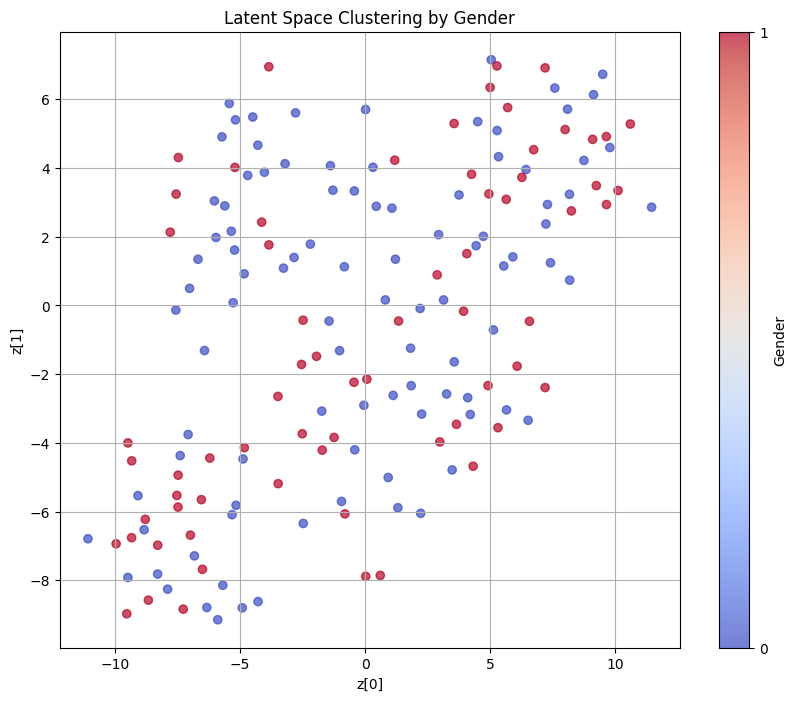

In [155]:
y_colormap = (y_test.flatten() + 1) // 2

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_colormap, cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label="Gender")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Clustering by Gender")
plt.grid(True)
plt.show()

# The gender clusters are not well seperated, but I tried to generate male/female images and it seems to be not bad...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


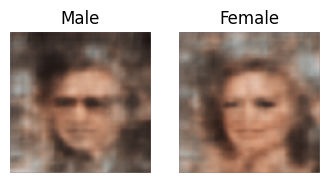

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# generate a random latent z
latent_dim = 8
z_sample = np.random.normal(size=(1, latent_dim))

# condition label：-1 = female，1 = male
label_male = np.array([[1]])
label_female = np.array([[-1]])

# generate male/female image
img_male = cvae.decoder.predict([z_sample, label_male])
img_female = cvae.decoder.predict([z_sample, label_female])

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Male")
plt.imshow(img_male[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Female")
plt.imshow(img_female[0])
plt.axis('off')
plt.show()